In [27]:
import numpy as np 
from glob import glob
import os
from astropy.io import fits
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, savgol_filter
from scipy.optimize import curve_fit
from scipy import interpolate
from astropy.modeling.models import Gaussian1D
from astropy.modeling.fitting import LevMarLSQFitter


In [28]:
%cd /home/srinivas/Documents/observation_data_copy/Test/source_1/

/home/srinivas/Documents/observation_data_copy/Test/source_1


In [29]:
fits_file = fits.open('Feige_34bfc.fits')
data = fits_file[0].data
header = fits_file[0].header
xpixels = header['NAXIS1']
ypixels = header['NAXIS2']

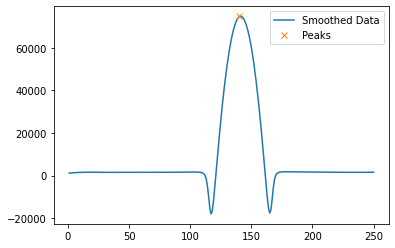

In [30]:


pixels_sum = []
xpixels_number = np.array(np.arange(1,xpixels+1,1))
xtrace = []
ytrace = []
for i in range(0,xpixels):
    midpoint = int(ypixels/2)
    nsum = np.arange(midpoint-10,midpoint+10,1)
    pixels = data[:,i][nsum]
    pixels_sum.append(np.sum(pixels))
pixels_sum = np.array(pixels_sum)

# Apply Savitzky-Golay filter to smooth the data
smoothed_pixels_sum = savgol_filter(pixels_sum, window_length=51, polyorder=3)

# Find peaks on the smoothed data
peaks, _ = find_peaks(smoothed_pixels_sum, prominence=500)

# Plot the smoothed data and the peaks
plt.plot(xpixels_number, smoothed_pixels_sum, label='Smoothed Data')
plt.plot(peaks, smoothed_pixels_sum[peaks], "x", label='Peaks')
plt.legend()
plt.show()

# Now you can use the peaks to find the xcenter
xcenter = xpixels_number[peaks]
ycenter = midpoint
#xtrace.append(xcenter)
#ytrace.append(ycenter)

xcenter_upper = xcenter
ycenter_upper = ycenter
midpoint_upper = midpoint
def gaussian(x, amplitude, mean, stddev):
    return amplitude * np.exp(-((x - mean) ** 2) / (2 * stddev ** 2))

while midpoint_upper<=(ypixels-500):
    midpoint_upper+=5
    pixels_sum_upper = []
    xpixels_number_upper = []
    for i in range(int(xcenter_upper-30),int(xcenter_upper+30)):    
        nsum_upper = np.arange(midpoint_upper-10,midpoint_upper+10,1)
        pixels_upper = data[:,i][nsum_upper]
        pixels_sum_upper.append(np.sum(pixels_upper))
        xpixels_number_upper.append(int(i))
    pixels_sum_upper = np.array(pixels_sum_upper)
    smoothed_pixels_sum_upper = savgol_filter(pixels_sum_upper, window_length=2, polyorder=1)
    peaks_upper, properties_upper = find_peaks(smoothed_pixels_sum_upper, prominence=50)
    prominences_upper = properties_upper['prominences']
    sorted_indices_upper = np.argsort(prominences_upper)[::-1]
    sorted_peaks_upper = peaks_upper[sorted_indices_upper]

    initial_guesses_upper = [max(pixels_sum_upper), xpixels_number_upper[sorted_peaks_upper[0]], 1]
    popt, _ = curve_fit(gaussian, xpixels_number_upper, smoothed_pixels_sum_upper, p0=initial_guesses_upper)
    fitted_mean_upper = popt[1]
    
    # Now you can use the peaks to find the xcenter
    xcenter_upper = xpixels_number_upper[sorted_peaks_upper[0]]
    ycenter_upper = midpoint_upper
    xtrace.append(fitted_mean_upper)
    ytrace.append(ycenter_upper)


xcenter_lower = xcenter
ycenter_lower = ycenter
midpoint_lower = midpoint
while midpoint_lower>=30:
    midpoint_lower -= 5
    pixels_sum_lower = []
    xpixels_number_lower = []
    for i in range(int(xcenter_lower-30),int(xcenter_lower+30)):    
        nsum_lower = np.arange(midpoint_lower-10,midpoint_lower+10,1)
        pixels_lower = data[:,i][nsum_lower]
        pixels_sum_lower.append(np.sum(pixels_lower))
        xpixels_number_lower.append(int(i))
    pixels_sum_lower = np.array(pixels_sum_lower)
    smoothed_pixels_sum_lower = savgol_filter(pixels_sum_lower, window_length=2, polyorder=1)
    peaks_lower, properties_lower = find_peaks(smoothed_pixels_sum_lower, prominence=50)
    prominences_lower = properties_lower['prominences']
    sorted_indices_lower = np.argsort(prominences_lower)[::-1]
    sorted_peaks_lower = peaks_lower[sorted_indices_lower]

    initial_guesses_lower = [max(pixels_sum_lower), xpixels_number_lower[sorted_peaks_lower[0]], 1]
    popt, _ = curve_fit(gaussian, xpixels_number_lower, smoothed_pixels_sum_lower, p0=initial_guesses_lower)
    fitted_mean_lower = popt[1]
    xcenter_lower = xpixels_number_lower[sorted_peaks_lower[0]]
    ycenter_lower = midpoint_lower
    xtrace.append(fitted_mean_lower)
    ytrace.append(ycenter_lower)



In [31]:
zipped_lists = sorted(zip(ytrace, xtrace))
sorted_ytrace, sorted_xtrace = zip(*zipped_lists)

# Convert the zipped lists back to regular lists
sorted_ytrace = list(sorted_ytrace)
sorted_xtrace = list(sorted_xtrace)

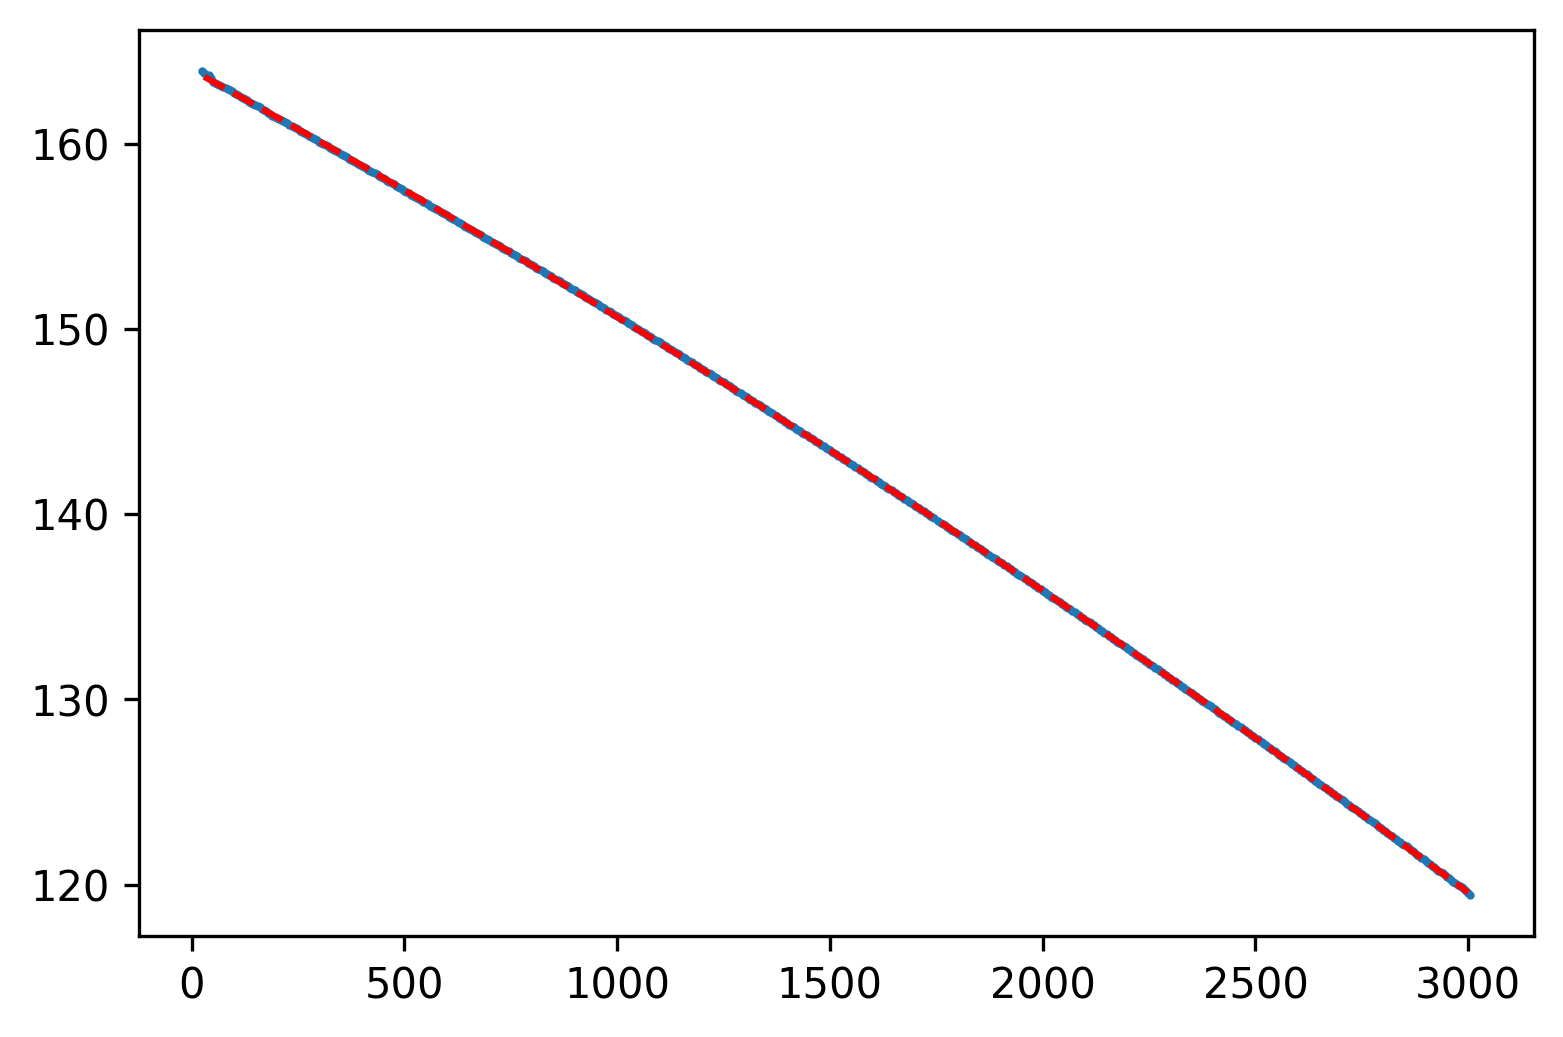

In [32]:
spline = interpolate.UnivariateSpline(sorted_ytrace, sorted_xtrace, k=3, s=20)
y_fit = spline(sorted_ytrace)
xvalues = np.arange(30,ypixels-499,1)
yvalues = spline(xvalues)
plt.figure(dpi=300)
plt.scatter(sorted_ytrace, sorted_xtrace, s=1)
plt.plot(xvalues,yvalues, ls='--', c="red")

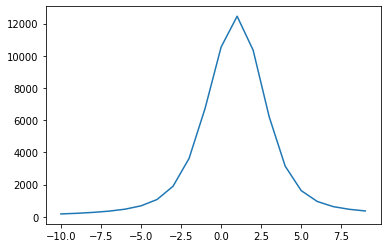

In [33]:
extracted_trace_start = np.round(yvalues) - 10
extracted_trace_end = np.round(yvalues) + 10
cutout_data = np.zeros((len(yvalues), 20)) 
for i in range(len(yvalues)):
    for j in range(0,20):
        cutout_data[i,j] = data[i,int(extracted_trace_start[i])+j]
background = np.median(data)
mean_trace_profile = (cutout_data - background).mean(axis=0)
trace_profile_xaxis = np.arange(-10, 10,1)
plt.plot(trace_profile_xaxis, mean_trace_profile)


In [34]:
lmfitter = LevMarLSQFitter()
guess = Gaussian1D(amplitude=mean_trace_profile.max(), mean=0, stddev=5)
fitted_trace_profile = lmfitter(model=guess, x=trace_profile_xaxis, y=mean_trace_profile)
model_trace_profile = fitted_trace_profile(trace_profile_xaxis)
fitted_trace_profile

<Gaussian1D(amplitude=11974.05154269, mean=0.9339209, stddev=1.91700515)>

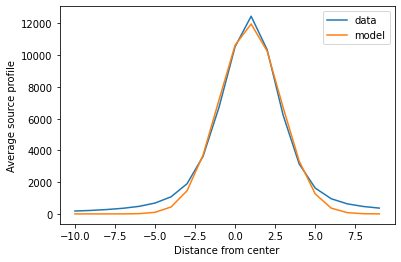

In [35]:
plt.plot(trace_profile_xaxis, mean_trace_profile, label='data')
plt.plot(trace_profile_xaxis, model_trace_profile, label='model')
plt.legend(loc='best')
plt.xlabel("Distance from center")
plt.ylabel("Average source profile");

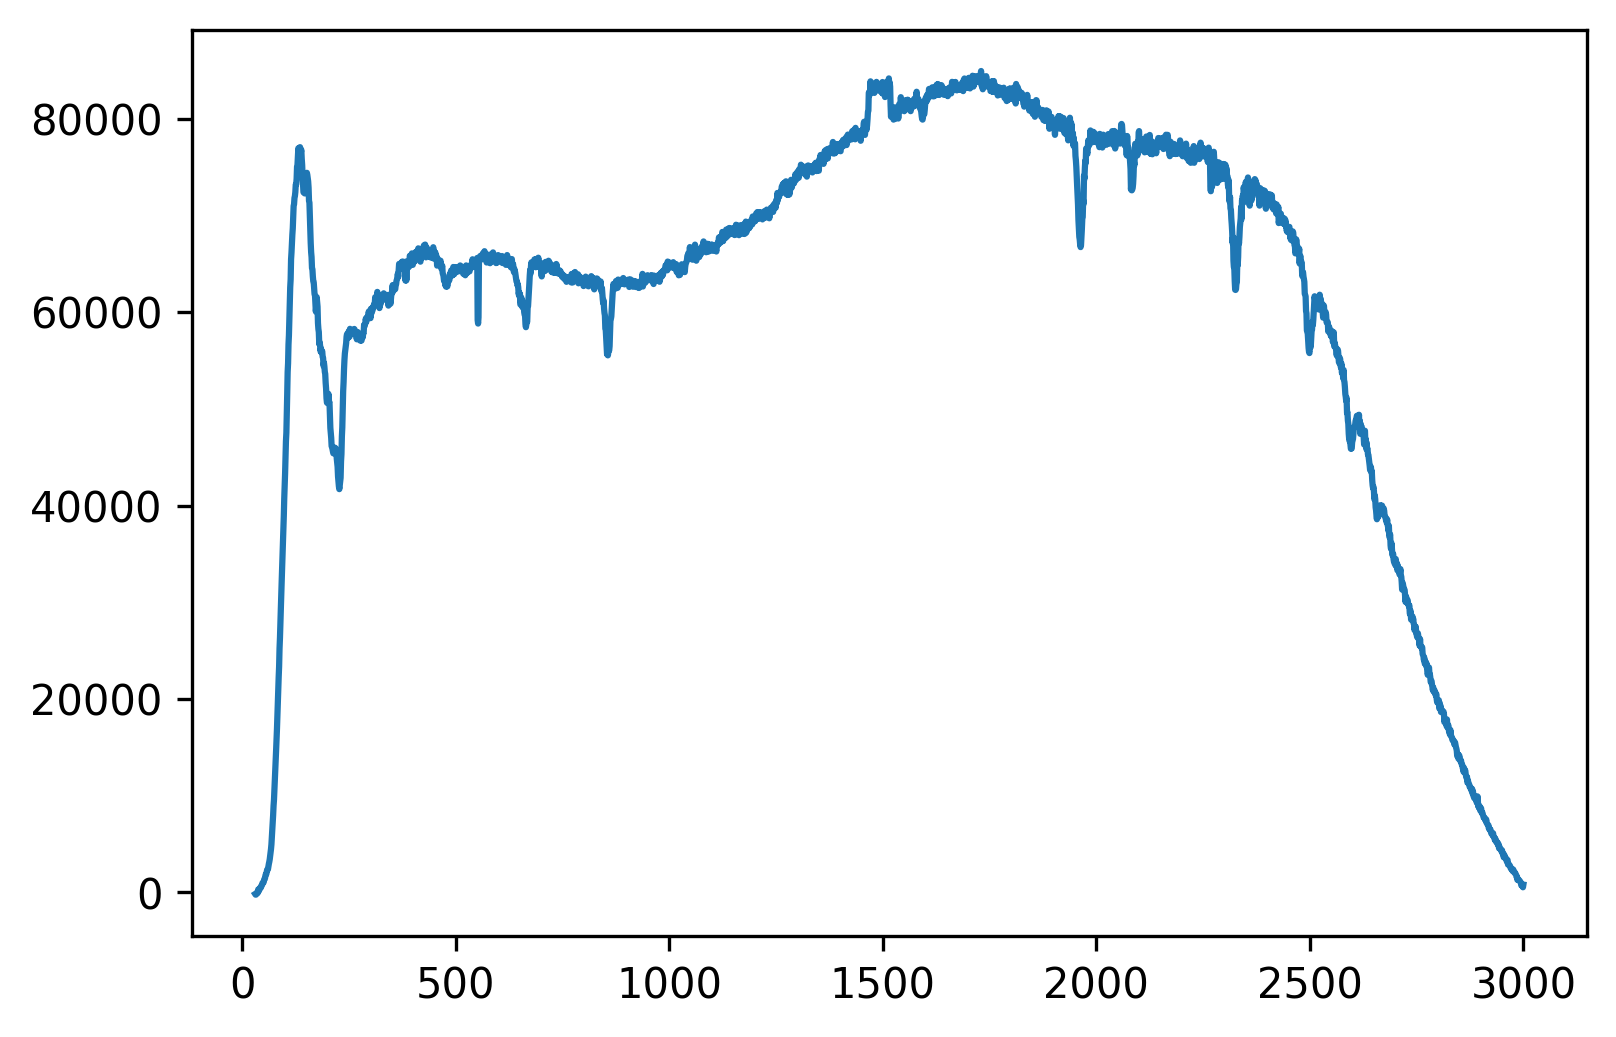

In [36]:
average_spectrum = (cutout_data - background).sum(axis=1)
plt.figure(dpi=300)
plt.plot(xvalues,average_spectrum);

In [46]:
from glob import glob
import os
with open('/home/srinivas/Documents/python/spectroscopy/user_input.txt', 'r') as file:
    lines = file.readlines()


path = lines[0].strip()
source = sorted(glob(os.path.join(path,'*src_bfc.fits')))
standard = sorted(glob(os.path.join(path,'*std_bfc.fits')))
source_lamp = sorted(glob(os.path.join(path,'*src_lamp_bfc.fits')))
standard_lamp = sorted(glob(os.path.join(path,'*std_lamp_bfc.fits')))

source_new = os.path.join(path, source[0].replace('.fits','ap.fits'))
source_new

'/home/srinivas/Documents/observation_data_copy/Test/source_1/J0746m1611src_bfcap.fits'

In [38]:
fits_file_lamp = fits.open('/home/srinivas/Documents/observation_data_copy/Test/source_1/Feige_34_FeArstd_lamp_bfc.fits')
data_lamp = fits_file_lamp[0].data
header_lamp = fits_file_lamp[0].header

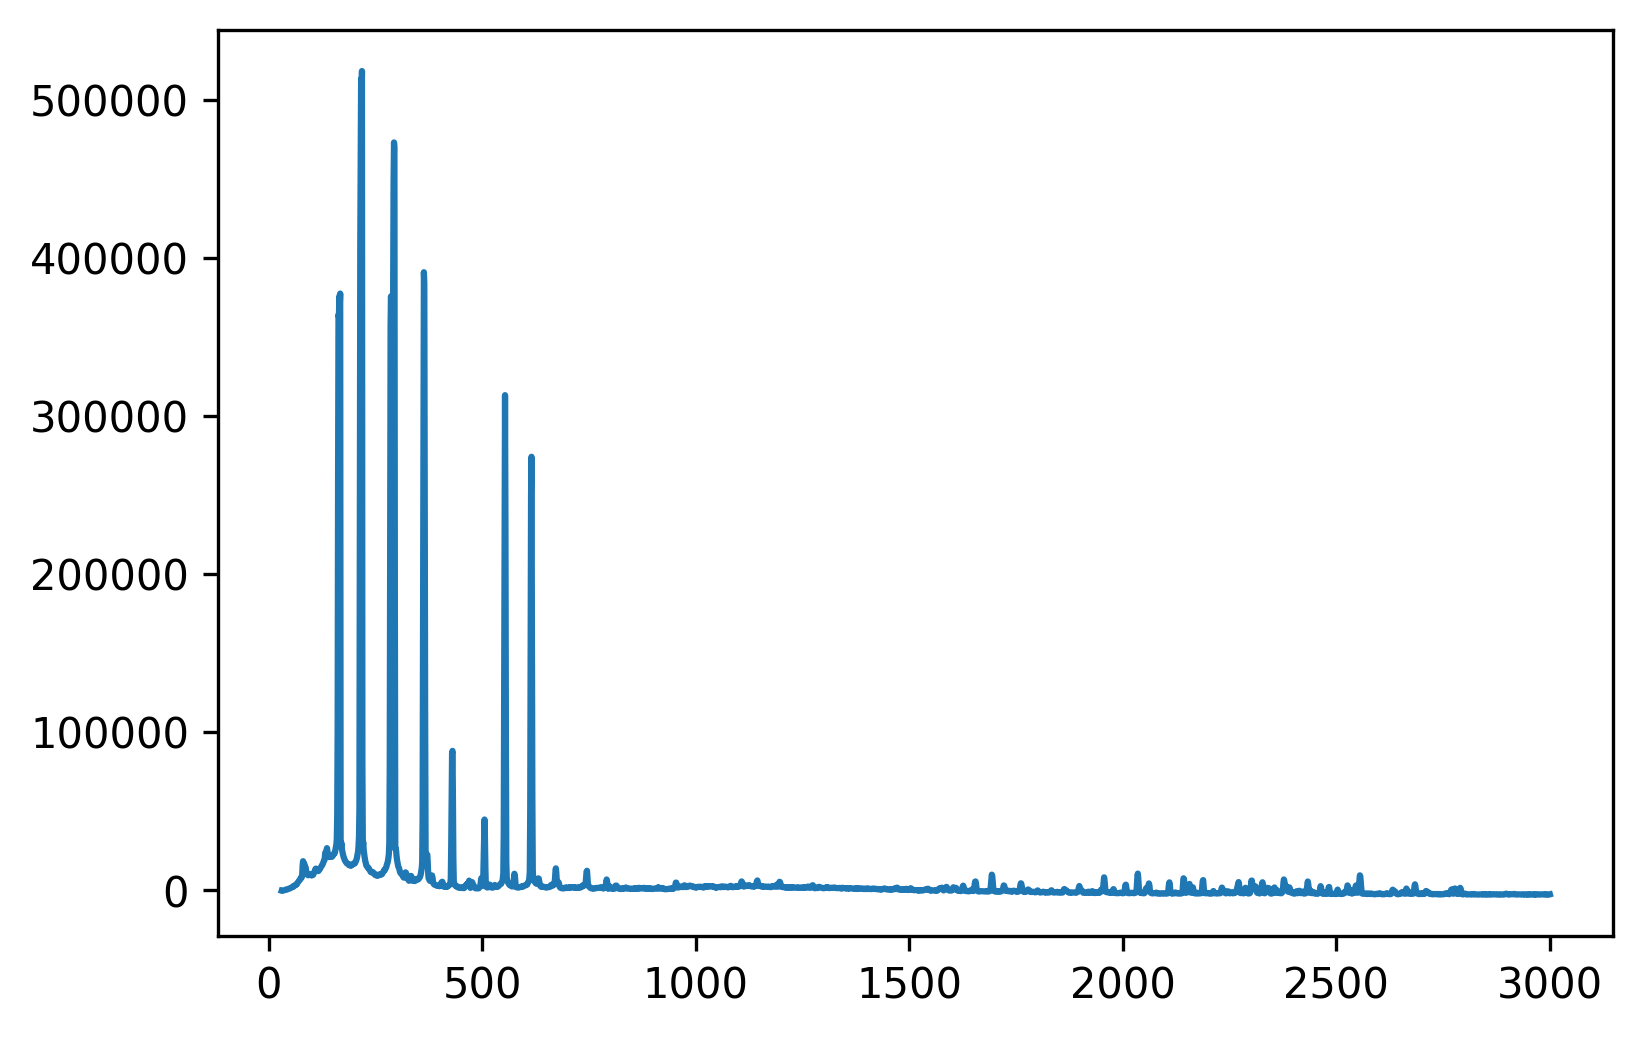

In [41]:
cutout_data_lamp = np.zeros((len(yvalues), 20)) 
for i in range(len(yvalues)):
    for j in range(0,20):
        cutout_data_lamp[i,j] = data_lamp[i,int(extracted_trace_start[i])+j]
background_lamp = np.median(data_lamp)
average_spectrum_lamp = (cutout_data_lamp - background_lamp).sum(axis=1)
plt.figure(dpi=300)
plt.plot(xvalues,average_spectrum_lamp);

In [51]:
final_image_1 = np.zeros((len(xvalues), len(average_spectrum)))
for i in range(len(xvalues)):
    for j in range(len(average_spectrum)):
        final_image_1[i, j] = average_spectrum[j]

In [52]:
sample = fits.open('/home/srinivas/Downloads/scidoc2214.fits')

In [66]:
data = sample[0].data
step = (10900-3000)/len(data)
xaxis = np.arange(3000,10900,step)

(0.0, 500000.0)

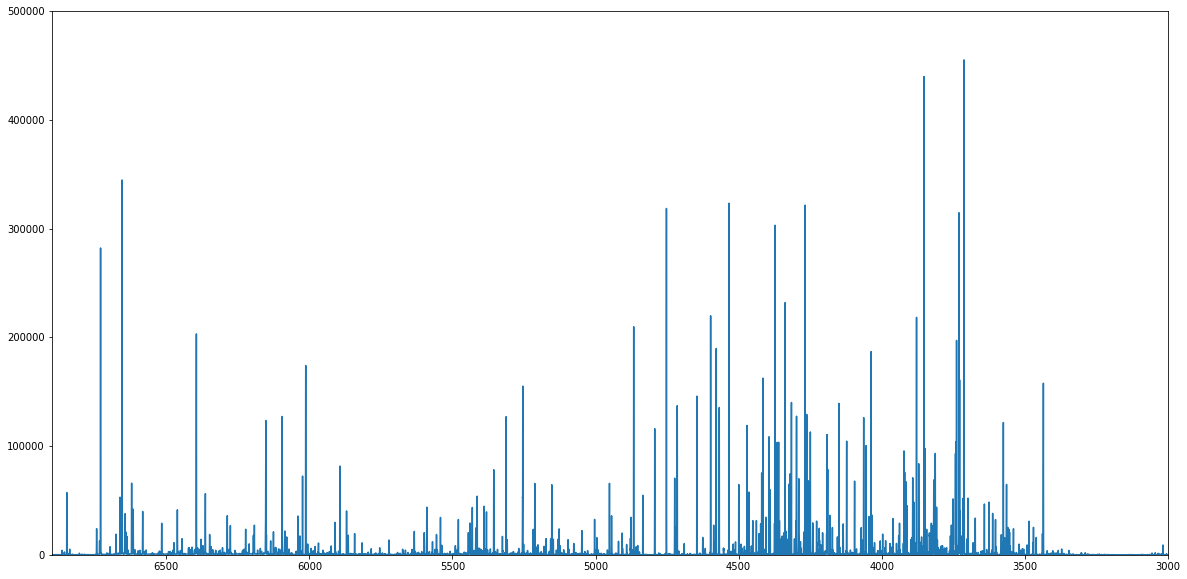

In [80]:

plt.figure(figsize=(20,10))
plt.plot(xaxis, data)
plt.xlim(6900,3000)
plt.ylim(0,500000)